In this notebook, we will do an analysis of the Titanic dataset trying to predict if a passenger is likely to survive or not, first we will load our dataset and do some basic cleaning on the resulting dataframe.

In [2]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
import pingouin as pg

titanic = pd.read_csv("train.csv")
titanic.info()
print(titanic.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


As you can see from the output, the data is very dirty, containing lots of not valid values, in the columns Age, Cabin and Embarked. We will deal with each of those columns in a different way, first let's deal with the Cabin column the most problematic one

In [3]:
titanic['Cabin'] = titanic['Cabin'].notnull()

The above code assigns new boolean values to the Cabin column, basically, if the cell was a valid value, it is now True, if it was not valid, it is now False. We could have also dropped the entire column since there was a huge amount of missing data, but keeping at least a shadow of that data might prove valuable later, so we went with this route.

Next we will deal with the Embarked column

In [4]:
titanic["Embarked"].fillna(value=titanic["Embarked"].mode()[0],inplace=True)

We dealt with the missing values in this column in a simple way, by substituting them by the mode. This should not affect out visualisations and predictions since its a very small amount of values being changed, and we keep the rest of the data in those rows.

Now to deal with the most problematic one, the Age

In [5]:
titanic["Age"].interpolate(method="linear",inplace=True)

There were many ways to deal with this column, we will discuss some of them before going on to the one that was chosen.

One option would be to just drop the column since there is a lot of missing data. But in this case, we know that age is most likely an important factor for the survival of the passenger ("Ladies and children first!") so losing such important data would not be good for the rest of the study.

Another option would be to drop the problematic rows from the dataframe. However, here we would lose a much larger number of rows, which would lower the amount of overall data available for the study to a point where it could affect the results.

We could also substitute the NaN values for the mean value of the column, commonly called Mean Imputation. That would keep the data contained in the problematic rows, but it would cause problems with the visualisation techniques used in the second pass and could have unwanted effects on any models we train with the resulting data.

There is also the option of filling in the value with the one just previous to it, commonly called Last Observation Carried Forward or LOCF for short. This approach can introduce bias and distort variability since you will have more repeating values. It also is flawed in the way that it assumes the data is random, which we cannot be sure in this dataset.

Finally to the chosen technique, Interpolation:

Interpolation works by using a mathematical function to approach the missing values. It has problems, such as the high computational cost, and it might not work well for data that has a nonlinear relationship, but it is a good choice for handling the problem posed by this column, it solves the problems of the two drop solutions since it keeps the previously present data, addresses the visualization problems caused from Mean Imputation and is overall better fitted to this dataset than LOCF.

For this reason we went with Interpolation as the chosen method, the linear interpolation method was picked for being simpler and less computationally intensive than more complex methods such as spline and polynomial but still giving good results.

In [6]:
print(titanic.isna().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


As you can see from the output given, we now have a perfectly clean dataset to make our visualisations and predictions.

Before proceeding to the second pass, we should take a look at the data types. They are mostly good for this dataset, not needing any particular changes, besides for Parch and SibSp which we already did before.

Some columns contain outliers that can mess up our predictions, namely SipSb and Parch, we can make the situation better by categorizing any value of SibSp at or over 3 as >=3 and changing the column to an ordered categorical feature, and for Parch we can do the same since they both start to get outliers at about the same value.

In [7]:
def GtE3 (data):
    filteredData = []
    for cell in data:
        if (int(cell) >= 3):
            filteredData.append(">=3")
        else:
            filteredData.append(str(cell))

    return filteredData

titanic["SibSp"]=GtE3(titanic["SibSp"])

titanic["Parch"]=GtE3(titanic["Parch"])

titanic["SibSp"] = pd.Categorical(titanic["SibSp"], categories=['0', '1', '2','>=3'], ordered=True)

titanic["Parch"] = pd.Categorical(titanic["Parch"], categories=['0', '1', '2','>=3'], ordered=True)

titanic[["Parch","SibSp"]]

,Parch,SibSp
0,0,1
1,0,1
2,0,0
3,0,1
4,0,0
...,...,...
886,0,0
887,0,0
888,2,1
889,0,0


Those columns are now more digestible from a data analysis standpoint and may provide us with some more valuable data.

We can also infer some columns from the provided data that could prove useful to us, first let us add a boolean column that tells us if a passenger is underage or not.

In [8]:
titanic["isUnderage"] = np.where(titanic["Age"] < 18, True, False)
titanic[["Age","isUnderage"]]

,Age,isUnderage
0,22.0,False
1,38.0,False
2,26.0,False
3,35.0,False
4,35.0,False
...,...,...
886,27.0,False
887,19.0,False
888,22.5,False
889,26.0,False


We will also extract the titles from the names to give us a title column.

In [9]:
TitlesList = titanic["Name"].str.findall(r", .*\.")#applies a regex to the names in the list to get the titles, returns a list with the matching titles for each row

TitlesDirty = []

TitlesClean = []

for title in TitlesList:#unpackages the many lists created into simple strings
    TitlesDirty.append(title[0])

for title in TitlesDirty:#tidies up the resultant strings 
    title = title.strip(",")
    title = title.strip(" ")
    title = title.strip(".")
    TitlesClean.append(title)

titanic["Title"] = TitlesClean#creates the new column

titanic[["Name","Title"]]

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr
...,...,...
886,"Montvila, Rev. Juozas",Rev
887,"Graham, Miss. Margaret Edith",Miss
888,"Johnston, Miss. Catherine Helen ""Carrie""",Miss
889,"Behr, Mr. Karl Howell",Mr


In [10]:
titanic["Title"].value_counts()

Mr 517
Miss 182
Mrs 124
Master 40
Dr 7
Rev 6
Col 2
Mlle 2
Major 2
Ms 1
Mrs. Martin (Elizabeth L 1
Lady 1
Sir 1
Mme 1
Don 1
Capt 1
the Countess 1
Jonkheer 1
Name: Title, dtype: int64

This is already good, but there are too many unique values that occur very rarely. We can improve this by grouping up some of the more obscure titles with some of the more normal ones creating groups

In [11]:
simplifiedTitles =[]
for title in titanic["Title"]:
    if title == "Mlle" or title == "Ms" or title == "Miss":
        simplifiedTitles.append("Miss")
    elif title == "Mme" or title =="Mrs. Martin (Elizabeth L" or title == "Mrs":
        simplifiedTitles.append("Mrs")
    elif title =="Mr":
        simplifiedTitles.append("Mr")
    elif title =="Master":
        simplifiedTitles.append("Master")
    else:
        simplifiedTitles.append("rare_Title")

titanic["Title"] = simplifiedTitles

titanic[["Name","Title"]]

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr
...,...,...
886,"Montvila, Rev. Juozas",rare_Title
887,"Graham, Miss. Margaret Edith",Miss
888,"Johnston, Miss. Catherine Helen ""Carrie""",Miss
889,"Behr, Mr. Karl Howell",Mr


In [12]:
titanic["Title"].value_counts()

Mr 517
Miss 185
Mrs 126
Master 40
rare_Title 23
Name: Title, dtype: int64

We now have a more simplified version of the Title column which will be more useful for our data investigations.

Some columns have outliers and other kinds of undesirable features, namely Fare has a few outliers at value 0 and at very high values.I decided to leave the outliers in the data, since they are few and could reveal something important.

We could also make the ticket feature more useful by transforming it into another categorical boolean feature based on if the ticket had only the numbers or contained something before the numbers.

In [13]:
titanic["detailedTicket"] = titanic["Ticket"].str.contains(r" ")#simple regex that just looks for the space inbetween the numbers and the letters at the beginning

titanic[["Ticket","detailedTicket"]]

,Ticket,detailedTicket
0,A/5 21171,True
1,PC 17599,True
2,STON/O2. 3101282,True
3,113803,False
4,373450,False
...,...,...
886,211536,False
887,112053,False
888,W./C. 6607,True
889,111369,False


We will now proceed to analyse the individual features and their possible relationship to the target, starting with Sex.

<Axes: xlabel='Sex', ylabel='count'>

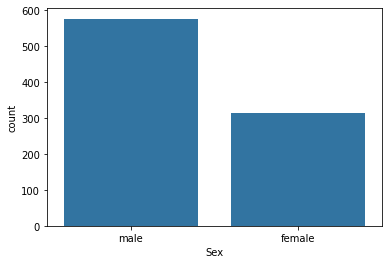

In [14]:
sns.countplot(data=titanic,x="Sex")

It is a simple categorical feature that applies to every single row. We can try and use a countplot with the hue indication survival to try and see if there is any correlation between Sex and Survived

<Axes: xlabel='Sex', ylabel='count'>

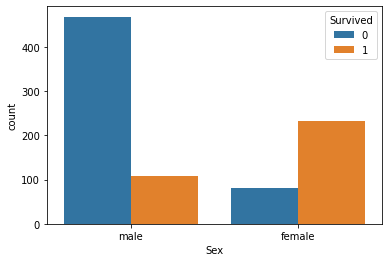

In [15]:
sns.countplot(data=titanic,x="Sex",hue ="Survived")

As we can see, there seems to be a huge correlation between Sex and Survived, as expected from the context.

We will proceed to analyse the Age feature which is numerical in nature, so we will start by generating a histplot to get a general sense of the data.

<Axes: xlabel='Age', ylabel='Count'>

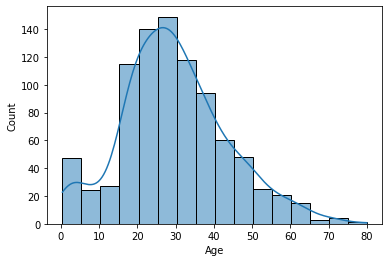

In [16]:
sns.histplot(data=titanic,x="Age",binwidth=5,kde=True)

As we can see, the Age feature follows something close to a normal distribution, but there are some abnormalities. Let's try geting a QQplot to get some details

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

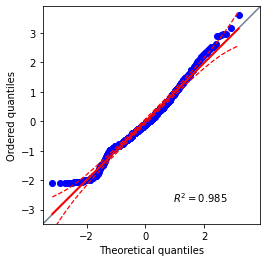

In [17]:
pg.qqplot(titanic["Age"],dist="norm")

As can be seen from the QQplot it is very close to a normal distribution, with the only significant discrepancy being in the very young, some might be inclined to delete or modify those values in some way, but with the context from the source of the data that deviation can be explained, parents would be more inclined to bring their younger children with them on the trip since they require more attention and other teenagers and young adults probably wouldn't have enough money to go on their own. That is my personal insight derived from the data and context, so I believe those values are actually quite important to predicting survival and will be keeping them as is. 

We will generate some violin plots to see if we can gain any more insights

<Axes: xlabel='Survived', ylabel='Age'>

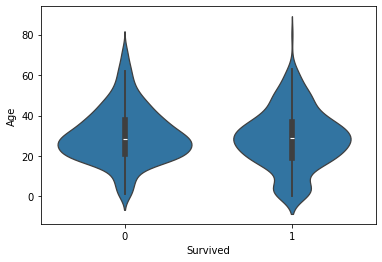

In [18]:
sns.violinplot(data=titanic,x="Survived",y="Age")

As expected, using the violin plot we can see that even though the average age is about the same for both survivors and those who did not make it, there is a distinctly larger "tail" on the plot for those who survived, which points us in the way of there being a correlation between Survived and Age

We can use the previously generated isUnderage column to get a quick visualisation of that

<Axes: xlabel='isUnderage', ylabel='count'>

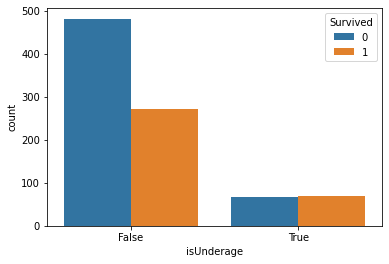

In [19]:
sns.countplot(data=titanic,x ="isUnderage",hue="Survived")

As predicted, there seems to be a significantly large percentage of survivors among the younger passengers, indicating a strong correlation.

We can also do a plot accounting for Age and Sex to try and gain some more insights.

<Axes: xlabel='Survived', ylabel='Age'>

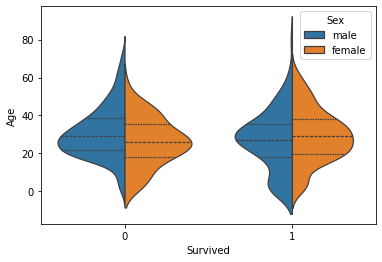

In [20]:
sns.violinplot(data=titanic,x="Survived",y="Age",hue ="Sex",split=True,inner="quart")

For females, there doesn't seem to be much correlation between Age and Survived, but for males, there is a clear correlation between Survived and Age.

This is an interesting feature that can affect later prediction and modeling tasks

We will now explore the Fare column, starting in the same way that we did with Age

<Axes: xlabel='Fare', ylabel='Count'>

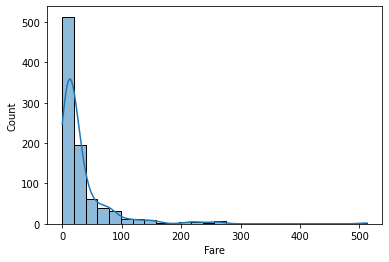

In [21]:
sns.histplot(data=titanic,x="Fare",binwidth=20,kde=True)

The distribution for Fare is more excentric than Age, but there still seems to be an overall distribution underlying that data. We can verify that with a QQplot

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

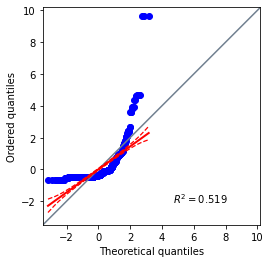

In [22]:
pg.qqplot(titanic["Fare"],dist="norm")

The Fare does not relate well to a normal distribution, we can try another distribution to see if we can find an apropriate one

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

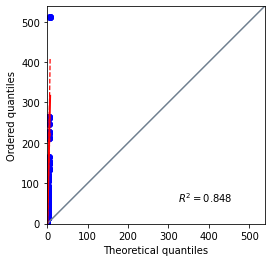

In [23]:
pg.qqplot(titanic["Fare"],dist="expon")

As can be seen from the $R^2$ value, the distribution of values in Fare falls closer to an exponential distribution.

We can try plotting another histogram with survived as the hue to see if there is any correlation between fare and survived.

<Axes: xlabel='Fare', ylabel='Count'>

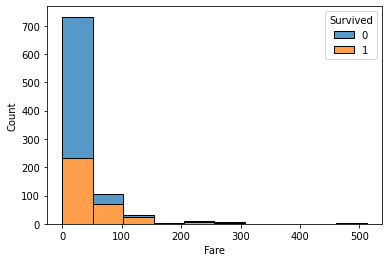

In [24]:
sns.histplot(data=titanic,x="Fare",hue="Survived",binwidth=50,multiple="stack")

There seems to be a slight correlation between Fare and Survived, with a larger percentage of passengers that paid a more expensive fare surviving. However, it is not so easy to tell with the current way the graph is plotted even with the larger bins, to try and solve that we can try using a log scale

<Axes: xlabel='Fare', ylabel='Count'>

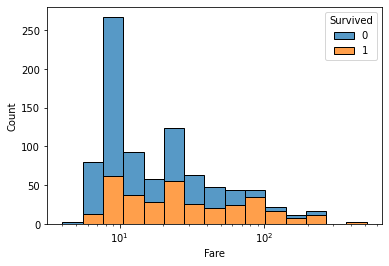

In [25]:
sns.histplot(data=titanic,x="Fare",hue="Survived",bins=15,multiple="stack",log_scale=True)

With the new graph the relationship is even more evident, showing us that Fare is probably a good predictor for survived

Next, let us explore the previously created Titles column. That column was created to try and extract some insight from the otherwise useless (from the data analysis perspective) names column. Since it had too many unique values for a categorical feature, we simplified it into a more digestible feature that should still retain the same correlations.

We will start with a simple countplot.

<Axes: xlabel='Title', ylabel='count'>

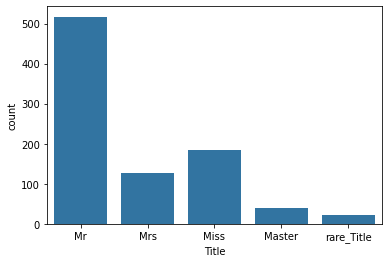

In [26]:
sns.countplot(data=titanic,x="Title")

We can try using a countplot to try and find correlations

<Axes: xlabel='Title', ylabel='count'>

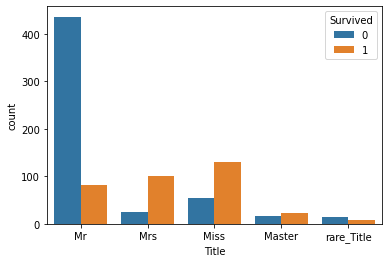

In [27]:
sns.countplot(data=titanic,x ="Title",hue="Survived")

At first glance, this feature seems of great importance, but wait, let's try and find some correlations between Title and some other previously studied features

<Axes: xlabel='Title', ylabel='count'>

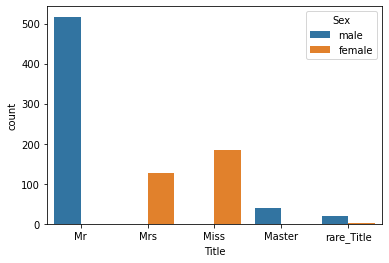

In [28]:
sns.countplot(data=titanic,x ="Title",hue="Sex")

This is not great, it seems that the titles that previously seemed correlated to survival and just another way to indicate Sex, which we already linked to Survival.

There is still hope, the Master title in particular seems interesting for being all male and having a higher than usual survival rate, but we must look for other correlations first.

<Axes: xlabel='Age', ylabel='Count'>

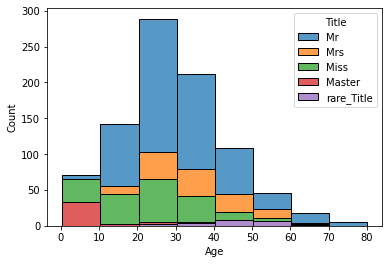

In [29]:
sns.histplot(data=titanic,x="Age",hue="Title",binwidth=10,multiple="stack")

This basically settles it, the other potentially useful title is related to Age, we already found out that Age is correlated to Survived, especially so in males, so younger males having a larger than usual change of surviving is no news.

Thus, the Title feature ended up proving itself not very useful, and most likely should not be a priority for prediction.

We will now take a quick look at Cabin to see if that can help us predict Survival

<Axes: xlabel='Cabin', ylabel='count'>

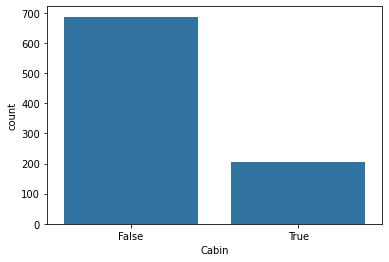

In [30]:
sns.countplot(data=titanic,x="Cabin")

As we can see, it is a simple False or True categorical feature, we can use the hue to try and see if thre is any correlation.

<Axes: xlabel='Cabin', ylabel='count'>

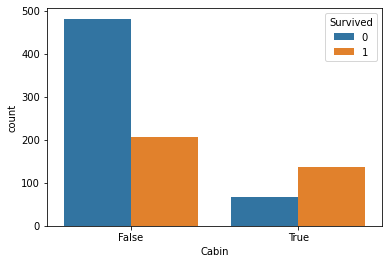

In [31]:
sns.countplot(data=titanic,x="Cabin",hue="Survived")

Interesting, the survival rate of the passengers with an assigned cabin is much higher than usual!

But wait, let's try and relate Cabin to Fare, since most passengers assigned cabins would most likely be paying a higher fare, and we already linked Fare to Survived.

<Axes: xlabel='Fare', ylabel='Count'>

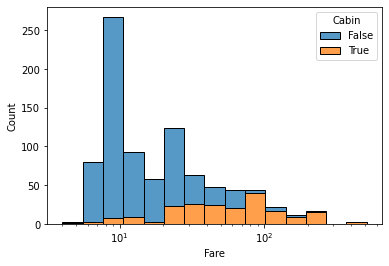

In [32]:
sns.histplot(data=titanic,x="Fare",hue="Cabin",bins=15,multiple="stack",log_scale=True)

So Cabin is also very closely related to Fare.

This shows us that Cabin would not be that useful for predicting Survived when we have Fare which is a richer feature already, we will discuss more problems that can arise from that later.

Proceeding to analyze Pclass, starting with the familiar countplot.

<Axes: xlabel='Pclass', ylabel='count'>

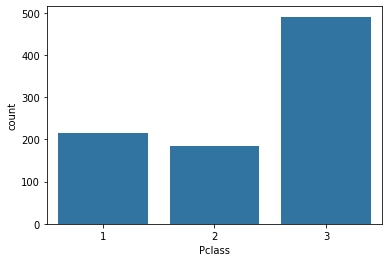

In [33]:
sns.countplot(data=titanic,x="Pclass")

It is another simple categorical feature, let's use the hue and try and see if there is a correlation between Pclass and Survived

<Axes: xlabel='Pclass', ylabel='count'>

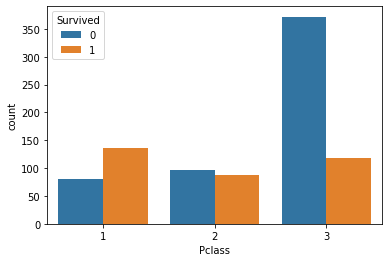

In [34]:
sns.countplot(data=titanic,x="Pclass",hue="Survived")

There seems to be some correlation between Pclass and Survived, but further exploration is needed.

Since we know the context of the dataset, it stands to reason that passengers in first class would pay a higher fare, so we can try and find a relation between Fare and Pclass 

<Axes: xlabel='Fare', ylabel='Count'>

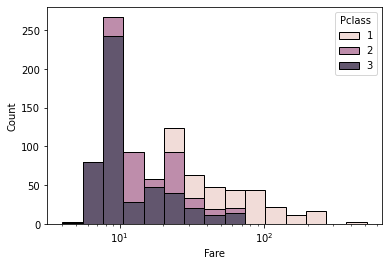

In [35]:
sns.histplot(data=titanic,x="Fare",hue="Pclass",bins=15,multiple="stack",log_scale=True)

As expected the Pclass is closely related to Fare which we already linked to the target.

This also could be a reason to not prioritize Pclass in out analysis. It could even cause problems if we were to try creating a model off of this data, since 2 other columns are closely related to Fare that can cause an overrepresentation and make our model overvalue Fare when predicting Survived, and the same goes for Cabin.

The SibSp column stands for the number of siblings or spouses aboard, we will now explore it, beginning with the countplot

<Axes: xlabel='SibSp', ylabel='count'>

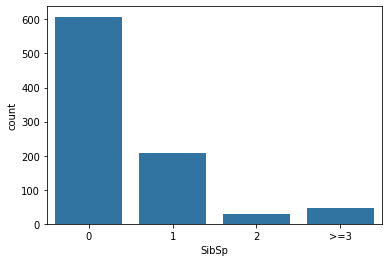

In [36]:
sns.countplot(data=titanic,x="SibSp")

Now using the Hue we will try to find a relationship between SibSp and Survived

<Axes: xlabel='SibSp', ylabel='count'>

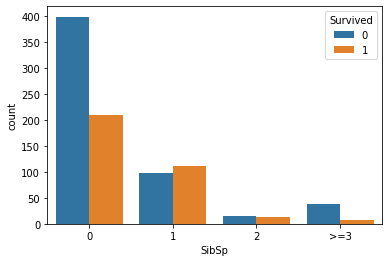

In [37]:
sns.countplot(data=titanic,x="SibSp",hue="Survived")

From the graphs there does seem to be a very strong correlation between Survived and SibSp but in the specific values on 1 and 2.

That is definitely curious and might make worth some more investigation into SibSp, it might be related to Age since young passengers would be more likely to have siblings aboard, we can check that with another histogram.

<Axes: xlabel='Age', ylabel='Count'>

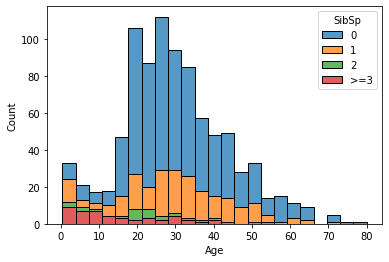

In [38]:
sns.histplot(data=titanic,x="Age",hue="SibSp",multiple="stack")

The correlation between SibSp doesn't seem too strong, since the highest survival rate was for SibSp = 1, if SibSp was a better indicative of age that could be one way of rationalizing the correlation, but in fact, one of the predominant cattegories in young children was >=3 and that was a category with remarkably low survival rates. 

That tells us that SibSp could be useful to predicting the Target and should be a factor in our observations.

Parch stands for the number of Parents and Children aboard, this feature has a very similar structure to SibSp and could be correlated in some way, but first we should take a look at its distribution.

<Axes: xlabel='Parch', ylabel='count'>

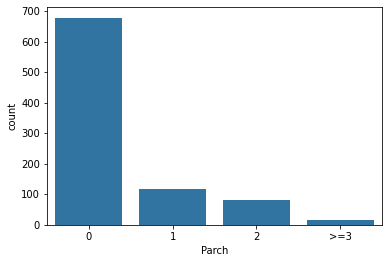

In [39]:
sns.countplot(data=titanic,x="Parch")

As expected, it follows a similar pattern to SibSp we can use the Hue feature to see if it is related to the target in the same way as SibSp

<Axes: xlabel='Parch', ylabel='count'>

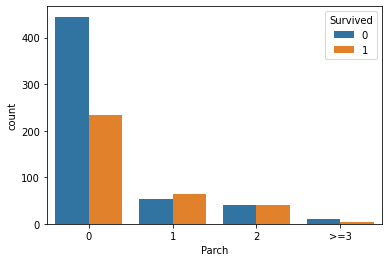

In [40]:
sns.countplot(data=titanic,x="Parch",hue="Survived")

The relationship to the target is very similar, that could mean that they are very closely related to eachother, we can try and verify that with another plot. 

<Axes: xlabel='Parch', ylabel='Count'>

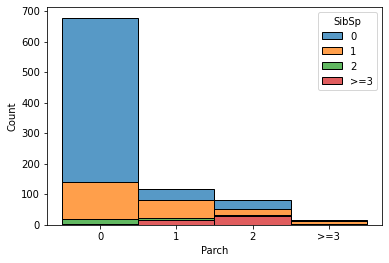

In [41]:
sns.histplot(data=titanic,x="Parch",hue="SibSp",multiple="stack")

They do not seem very closely related outside of value 0 and slightly related at value 1, that tells us that they probably aren't very good predictors for each other and should be evaluated separately.

That being said, Parch could be useful in predicting the target and should be included in our analysis.

The last remaining useful feature is Embarked, which we will proceed to analyzing starting with the countplot.

<Axes: xlabel='Embarked', ylabel='count'>

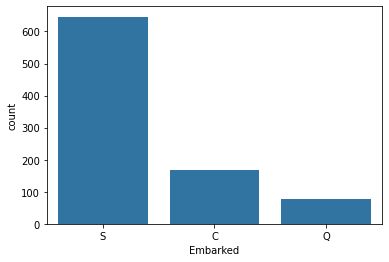

In [42]:
sns.countplot(data=titanic,x="Embarked")

As we can see most of the passengers embarked in Southampton. Now to the hue to see the relationship with the target

<Axes: xlabel='Embarked', ylabel='count'>

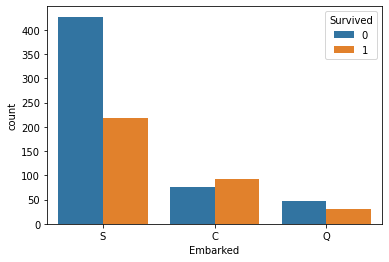

In [43]:
sns.countplot(data=titanic,x="Embarked",hue="Survived")

Interestingly, the survival rate of passengers that embarked at Queenstown and Cherbourgh are higher. This could be for many reasons personally I suspect that the average fare for those Ports could be higher, we can use a histogram to visualize that 

<Axes: xlabel='Fare', ylabel='Count'>

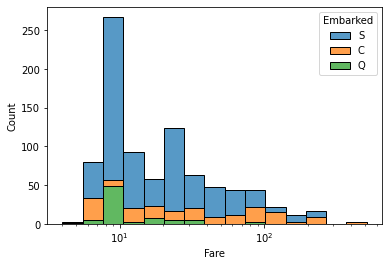

In [44]:
sns.histplot(data=titanic,x="Fare",hue="Embarked",bins=15,multiple="stack",log_scale=True)

There seems to be a slightly larger number of passengers that paid a higher fare and embarked at Cherbourgh but besides that they do not seem closely related, in fact, most of the passengers that embarked at Queenstown paid a lower fee on average and had an above average survival rate.

This means that Embarked could probably be a good predictor for the target

Finally, we will analyze the detailedTicket feature, staring with the simple countplot

<Axes: xlabel='detailedTicket', ylabel='count'>

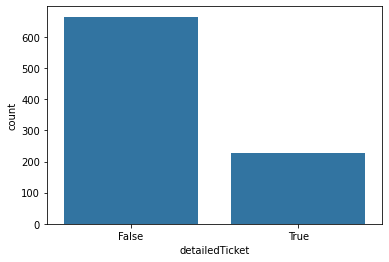

In [45]:
sns.countplot(data=titanic,x="detailedTicket")

Most of the tickets do not have details, so we will try using the hue to see if maybe that could be a good predictor for the target.

<Axes: xlabel='detailedTicket', ylabel='count'>

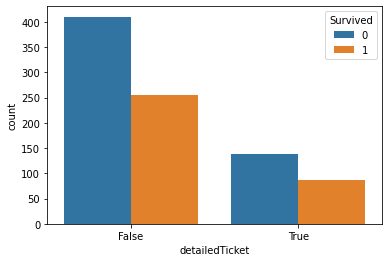

In [46]:
sns.countplot(data=titanic,x="detailedTicket",hue="Survived")

There does not seem to be any correlation between the detailed tickets and survival, so will end up not using it for our analysis.

We will now proceed to some correlation visualization techniques, they will allow us to review our observations and maybe find some relationships that we did not detect earlier, stanting with the Pearson's coeficcient, it is a value ranging from -1 to 1 that tells us how closely related two numerical features are.

<Axes: >

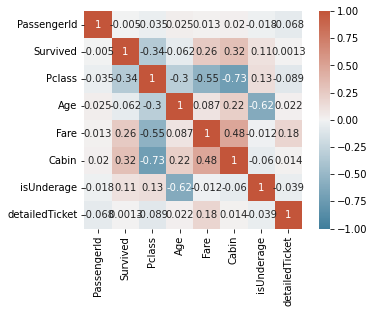

In [47]:
corr = titanic.corr(method="pearson",numeric_only=True)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, square=True, vmin=-1, vmax=1, cmap=cmap,annot=True)

As expected, this shows us that there seems to be a relationship between the target and Pclass, Cabin and Fare. This confirms our observations as it also shows that Pclass and Cabin are very closely related to Fare, and thus usually we would not consider each of them separately.

Interestingly, the Pearson coefficient of Survived and Age is surprisingly low, with the one for isUnderage being slightly higher, this goes against our observations, but different coefficients might show that relationship better.

There is also a notable correlation between Cabin and Age which didn't show up up in earlier observations and could mean that Cabin is more useful than it seemed at first. 

DetailedTicket also proved itself as basically unrelated to survival, being mroe close to Fare, Pclass and Cabin.

Now the next coefficient is the Spearman's Rank correlation coefficient.

<Axes: >

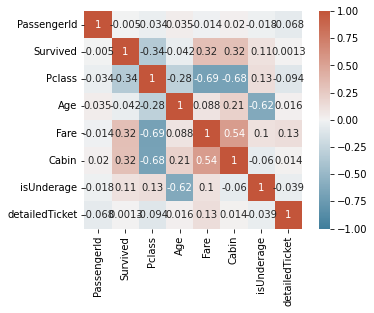

In [49]:
corr = titanic.corr(method="spearman",numeric_only=True)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, square=True, vmin=-1, vmax=1, cmap=cmap,annot=True)

The Spearman's Rank correlation coefficient also does not support categorical values and did not show any significant changes to the values observed with the Pearson's method.

I suspect that since the Age was a better predictor of Survived for males and Sex is a categorical feature not supported by the previous models the relationship is not so clear with them.

Now to Phik correlation coefficient, one that supports categorical features.

interval columns not set, guessing: ['PassengerId', 'Survived', 'Pclass', 'Age', 'Fare']


<Axes: >

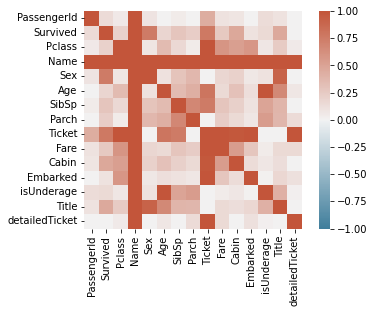

In [50]:
import phik
corr = titanic.phik_matrix()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, square=True, vmin=-1, vmax=1, cmap=cmap)

Phik still does not show the correlation between Survived and Age, which probably is because that correlation realies on another feature and the algorythm cannot interpret that, but we have seen that for males age is an importatn predictor for Survived.

Parch and SibSp also do not seem to have as strong of correlation to target as we thought, but that could be due to the low sample size and it only being an occasional relationship mainly in the values of 1 and 2, and according to Phik they are more closely related than expected.

Sex also shows up as another strong correlation to the target with Phik, as we expected from earlier observations.

Title also has some potential, but as we saw earlier, it is a better predictor for Age and Sex than for the target, and the relationship between Title and Survived is mostly tangential.

Pclass, Cabin and Fare are also good predictors for the target but are very closely related to themselves, so especially if we were to build a model with this data, we should either merge them in some way or ignore some of them as to not overemphasize one feature.

Embarked doesn't show up as a good predictor for the target and also is related to Fare and Pclass so maybe it should be put together with those.

Since Name has no repeating values it technically is an amazing predictor for everything due to the way that the algorythm calculates correlation, but in reality just knowing the name of a passenger would not tell us anything besides what we can get with the title especially if it was a passenger not in this dataset but instead in another testing set for a machine learning model for example, so due to the high variability and problems with later training Name should be mostly ignored and Title can be used in its place.

Ticket also has the same problems as Name, so even though the Phink method suggests that it could be a good predictor it should usually be ignored and if needed detailedTicket shoudl be used in its place, which reveals that without the high variability the Ticket data cannot be reliably used.



In conclusion, Sex is one of the best predictors for survival, followed by Pclass, Cabin, Fare which ideally would be merged into one column in some way if we were to train a model with this data, another important feature is Age, which by itself isn't so useful, but when paired with sex it can be a good predictor. Parch and SibSp could also be included in models but should be ideally averaged out together into a new feature, and even then using them could be dangerous due to their low variability, which could induce bias.Embarked also has potential, but due to its possible relation to Pclass, Cabin and Fare it should maybe just be included in the new column with them. Title also could be used but is not ideal since it is also very closely related to Sex and Age. Ticket should be ignored as well as detailedTicket and Name, as they are not good predictors for survival.